# Einlesen der Daten

In [163]:
import pandas as pd
from sklearn.utils import shuffle

df = pd.read_csv('tagged_dataset.csv', encoding='UTF-8').dropna()
df = df[~df['genre'].isin(['NEWS-P4'])]  # remove invalid genre (only one document)
df = shuffle(df, random_state=42)
#df['n_chars'] = df.tokens.apply(lambda x: len(x.split())) 
df.shape

(629, 9)

In [164]:
df.head()

,Unnamed: 0,genre,lemmas,period,pos_tags,region,title,tokens,year
500,500,NEWS,Aufforderung an die Herr Pfarrer und Schullehr...,P4,"NN APPR ART NN NN KON NN $. PPER $, PRELS ART ...",OOD,Badisches,Aufforderung an die Herrn Pfarrer und Schulleh...,1832
248,248,SERM,"so , mein Zuhörer , haben wir dies Augenblick ...",P5,"ADV $, PPOSAT NN $, VAFIN PPER PDAT NN APPR AR...",NoD,Sonntag,"So , meine Zuhörer , haben wir diesen Augenbli...",1861
557,557,NEWS,Breslau von+die @card@ . Januar . gestern sein...,P4,NE APPRART CARD $. NN $. ADV VAFIN APPRART NN ...,OMD,Neue,Breslau vom 19 . Januar . Gestern war zur Feie...,1821
217,217,SERM,"eine höchst bedeutungsvoll Fest sein es , mein...",P5,"ART ADV ADJA NN VAFIN PPER $, PPOSAT NN $, PRE...",NoD,Gegenwärtige,"Ein höchst bedeutungsvolles Fest ist es , mein...",1853
538,538,LEGA,die Polizei = Verordnung für Berlin . systemat...,P4,ART NN $( NN APPR NE $. ADJD VVPP APPR NE NE $...,NoD,DiePolizei=VerordnungfürBerlin,Die Polizei = Verordnungen für Berlin . System...,1850


# Trennen von Trainings- und Testdaten

In [165]:
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(df, random_state=42, test_size=0.2)

# Feature Extraction

In [209]:
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from scipy.sparse import hstack
from stop_words import get_stop_words

# tfidf values for tokens (n_grams)
cv_token = TfidfVectorizer(max_features=6000, stop_words=get_stop_words('de'))
X_token_train = cv_token.fit_transform(df_train.tokens)
X_token_test = cv_token.transform(df_test.tokens)

# tfidf values for lemmas (n_grams)
cv_lemma = TfidfVectorizer(max_features=6000, stop_words=get_stop_words('de'))
X_lemma_train = cv_lemma.fit_transform(df_train.lemmas)
X_lemma_test = cv_lemma.transform(df_test.lemmas)

# Only count pos tags
cv_pos = CountVectorizer()
X_pos_train = cv_pos.fit_transform(df_train.pos_tags)
X_pos_test = cv_pos.transform(df_test.pos_tags)

# Concatenate features horizontally
features = np.hstack([
    np.array(list(cv_token.vocabulary_.keys())),
    #np.array(list(cv_lemma.vocabulary_.keys())),
    #np.array(list(cv_pos.vocabulary_.keys()))
])

X_train = hstack([
    X_token_train,
    #X_lemma_train,
    #X_pos_train
])
X_test = hstack([
    X_token_test,
    #X_lemma_test,
    #X_pos_test
])

In [210]:
#train_lemma_pos = []
#for index, row in df_train.iterrows():
#    sample_lemma_pos = []
#    for lemma, pos in zip(row.tokens, row.pos_tags):
#        sample_lemma_pos.append("_".join((lemma, pos)))
#    train_lemma_pos.append(" ".join(sample_lemma_pos))
#
#test_lemma_pos = []
#for index, row in df_test.iterrows():
#    sample_lemma_pos = []
#    for lemma, pos in zip(row.tokens, row.pos_tags):
#        sample_lemma_pos.append("_".join((lemma, pos)))
#    test_lemma_pos.append(" ".join(sample_lemma_pos))
#
#merged_cv = TfidfVectorizer()
#X_train = merged_cv.fit_transform(train_lemma_pos)
#X_test = merged_cv.transform(test_lemma_pos)

In [211]:
y_train = df_train.genre
y_test = df_test.genre

In [212]:
features.shape

(6000,)

In [213]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((503, 6000), (503,), (126, 6000), (126,))

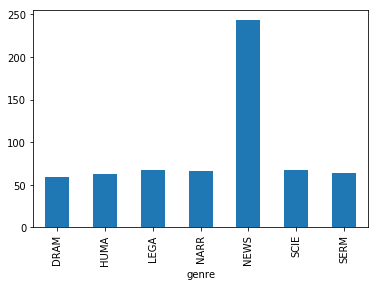

In [214]:
df.groupby('genre').genre.count().plot(kind='bar')

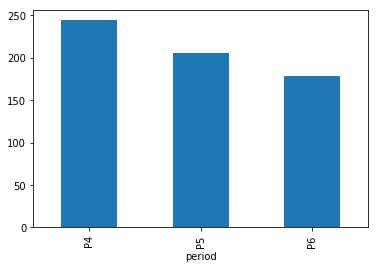

In [215]:
df.groupby('period').period.count().plot(kind='bar')

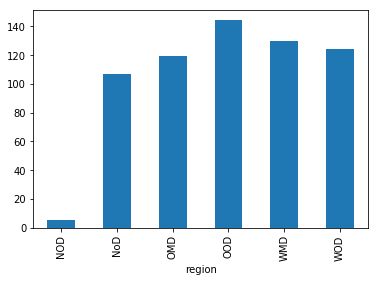

In [216]:
df.groupby('region').period.count().plot(kind='bar')

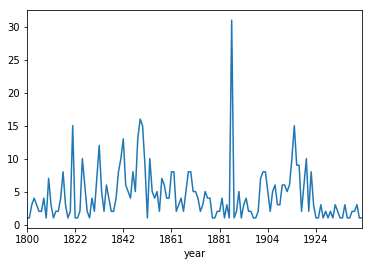

In [217]:
df.groupby('year').count().title.plot()

In [221]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression()
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)

from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

        DRAM       1.00      0.67      0.80         9
        HUMA       1.00      0.39      0.56        18
        LEGA       1.00      0.56      0.72        16
        NARR       1.00      0.71      0.83         7
        NEWS       0.69      1.00      0.82        53
        SCIE       1.00      0.92      0.96        13
        SERM       0.90      0.90      0.90        10

    accuracy                           0.80       126
   macro avg       0.94      0.74      0.80       126
weighted avg       0.86      0.80      0.79       126



/Users/lennartkeller/anaconda3/envs/nlp/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/lennartkeller/anaconda3/envs/nlp/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


In [222]:
from sklearn.naive_bayes import MultinomialNB

nb = MultinomialNB()
nb.fit(X_train, y_train)
y_pred = nb.predict(X_test)

from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

        DRAM       0.00      0.00      0.00         9
        HUMA       1.00      0.22      0.36        18
        LEGA       1.00      0.06      0.12        16
        NARR       0.62      0.71      0.67         7
        NEWS       0.58      1.00      0.74        53
        SCIE       1.00      0.77      0.87        13
        SERM       0.75      0.90      0.82        10

    accuracy                           0.65       126
   macro avg       0.71      0.52      0.51       126
weighted avg       0.71      0.65      0.57       126



/Users/lennartkeller/anaconda3/envs/nlp/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


# Check feature weights of logreg model to get highly correlated features for each class

In [229]:
n = 10
for class_ind, class_coef in enumerate(logreg.coef_):
    print(f'Class: {logreg.classes_[class_ind]}\n')
    print('Positive features:')
    positive_features = np.flip(np.argsort(class_coef)[-n:])
    for ind in positive_features:
        print(features[ind], class_coef[ind])
    print()
    print('Negative features:')
    negative_features = np.argsort(class_coef)[:n]
    for ind in negative_features:
        print(features[ind], class_coef[ind])
    print()
    print(f'{"#"*40}\n')

Class: DRAM

Positive features:
gegentheil 1.1168776229109407
wohnenden 0.9755407962198327
verkauft 0.9754816845430373
gärten 0.9084166180292803
deutlich 0.7557739263306165
juni 0.6822308755795017
glocken 0.678349680431095
leeren 0.6697304519421372
dgl 0.5965612969092163
liefern 0.5920875772853826

Negative features:
erneuerung -0.9240917203850607
adler -0.5069061117645597
brückenmann -0.46855265554726083
blind -0.46056152129935374
ernste -0.44745846211374807
einfluss -0.4441791436565297
stadium -0.40166178375262873
versäumt -0.39380103049899684
regelmäßig -0.3765781712578054
verbrennung -0.3479148362219842

########################################

Class: HUMA

Positive features:
pferde 1.2342384586317134
thra 1.0511022305047109
rz 0.9896629030787194
segen 0.8640424184898223
atmosphärischen 0.8506647600188473
königreich 0.7103007153165192
bewundern 0.6977310175785982
albert 0.6514678642737588
verursacht 0.60291458365507
tochter 0.5693112082607985

Negative features:
bestand -0.5519954

In [224]:
from sklearn.model_selection import GridSearchCV

linsvm_params = {
    'C': [0.1, 0.5, 1, 1.5, 2, 3, 4]
}

gridsearch_linsvm = GridSearchCV(
    LinearSVC(),
    cv=5,
    param_grid=linsvm_params,
    scoring='f1_macro',
    n_jobs=-1
)

gridsearch_linsvm.fit(X_train, y_train)
gridsearch_linsvm.best_params_, gridsearch_linsvm.best_score_

KeyboardInterrupt: 

In [ ]:
from sklearn.svm import LinearSVC

linsvm = LinearSVC()
linsvm.fit(X_train, y_train)
y_pred = linsvm.predict(X_test)

from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

In [ ]:
from sklearn.svm import SVC

rbfsvm = SVC(kernel='poly')
rbfsvm.fit(X_train, y_train)
y_pred = rbfsvm.predict(X_test)

from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

In [ ]:
from sklearn.tree import DecisionTreeClassifier

dectree = DecisionTreeClassifier()
dectree.fit(X_train, y_train)
y_pred = dectree.predict(X_test)

from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

In [ ]:
from sklearn.ensemble import RandomForestClassifier

randforest = RandomForestClassifier()
randforest.fit(X_train, y_train)
y_pred = randforest.predict(X_test)

from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

In [ ]:
from sklearn.linear_model import SGDClassifier

sgdsvm = SGDClassifier(loss='modified_huber', max_iter=15, random_state=42)

sgdsvm.fit(X_train, y_train)
y_pred = sgdsvm.predict(X_test)

from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.calibration import CalibratedClassifierCV

adaboost = AdaBoostClassifier(
    #base_estimator=SGDClassifier(loss='modified_huber', max_iter=5, random_state=42),
    #algorithm='SAMME.R',
    #n_estimators=100
)

adaboost.fit(X_train, y_train)
y_pred = adaboost.predict(X_test)

from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

In [ ]:
from xgboost.sklearn import XGBClassifier

grad_boost = XGBClassifier()
grad_boost.fit(X_train, y_train)
y_pred = grad_boost.predict(X_test)

from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

# Boostrap Validation

In [153]:
from sklearn.metrics import f1_score
from sklearn.utils import resample
from sklearn.base import BaseEstimator
from scipy.sparse import csr_matrix

def bootstrap_validation(clf1: BaseEstimator, clf2: BaseEstimator,
                         X: csr_matrix, y: csr_matrix,
                         n_samples: int,
                         sample_size: int,
                         scorer: callable = lambda y_true, y_pred: f1_score(y_true, y_pred, average='macro')) -> float:
    
    """
    Implementation of bootstrapping test according to Jurafsky.
    """
    
    # Compute initial performance difference on complete test set
    y_pred_1 = clf1.predict(X)
    clf1_score = scorer(y, y_pred_1)
    
    y_pred_2 = clf2.predict(X)
    clf2_score = scorer(y, y_pred_2)
    
    initial_difference = clf1_score - clf2_score
    
    # compute differences on n_samples different testsets
    sample_differences = []
    for _ in range(n_samples):
        
        # create boostrap sample
        X_sample, y_sample = resample(X, y,
                                      replace=True,
                                      n_samples=sample_size)
        
        # calculate performance difference and store it
        y_pred_1 = clf1.predict(X_sample)
        clf1_score = scorer(y_sample, y_pred_1)
    
        y_pred_2 = clf2.predict(X_sample)
        clf2_score = scorer(y_sample, y_pred_2)
        sample_differences.append(clf1_score - clf2_score)
    
    # calculate p value based on performance differences
    s_values = []
    s = 0
    for sample_difference in sample_differences:
        if sample_difference > 2 * initial_difference:
            s += 1
    p_value = s / n_samples
    
    return p_value

In [161]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB


clf1 = LogisticRegression().fit(X_train, y_train)
clf2 = MultinomialNB().fit(X_train, y_train)


print(f"F1-Score Macro for Classifier 1: {f1_score(y_test, clf1.predict(X_test), average='macro')}")
print(f"F1-Score Macro for Classifier 2: {f1_score(y_test, clf2.predict(X_test), average='macro')}")

bootstrap_validation(clf1, clf2,
                     X_test, y_test,
                     n_samples=20,
                     sample_size=100)

/Users/lennartkeller/anaconda3/envs/nlp/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/lennartkeller/anaconda3/envs/nlp/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


F1-Score Macro for Classifier 1: 0.8330271157857364
F1-Score Macro for Classifier 2: 0.6495289083092743


/Users/lennartkeller/anaconda3/envs/nlp/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


0.0

In [162]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC


clf1 = DecisionTreeClassifier().fit(X_train, y_train)
clf2 = LinearSVC().fit(X_train, y_train)


print(f"F1-Score Macro for Classifier 1: {f1_score(y_test, clf1.predict(X_test), average='macro')}")
print(f"F1-Score Macro for Classifier 2: {f1_score(y_test, clf2.predict(X_test), average='macro')}")

bootstrap_validation(clf1, clf2,
                     X_test, y_test,
                     n_samples=200,
                     sample_size=100)

/Users/lennartkeller/anaconda3/envs/nlp/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/lennartkeller/anaconda3/envs/nlp/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


F1-Score Macro for Classifier 1: 0.721313086638164
F1-Score Macro for Classifier 2: 0.6122093852517472


/Users/lennartkeller/anaconda3/envs/nlp/lib/python3.7/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


0.085

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

grad_boost_sklean = GradientBoostingClassifier()
grad_boost_sklean.fit(X_train, y_train)
y_pred = grad_boost_sklean.predict(X_test)

from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

In [ ]:
from keras.preprocessing.text import Tokenizer

tok = Tokenizer(num_words=20000)
tok.fit_on_texts(df_train.text)

Xk_train = tok.texts_to_matrix(df_train.text)
Xk_test = tok.texts_to_matrix(df_test.text)

In [ ]:
from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
yk_train = le.fit_transform(y_train)
yk_test = le.transform(y_test)

yk_train = to_categorical(yk_train)

from keras.models import Sequential
from keras.layers import Input, Dense, Dropout, Reshape

def build_model(num_words, n_classes, hiddenlayer_size=512, n_hiddenlayer=1):
    model = Sequential()
    model.add(Dense(hiddenlayer_size, input_shape=(num_words, ), activation='relu'))
    model.add(Dropout(0.5))
    for i in range(n_hiddenlayer):
        model.add(Dense(hiddenlayer_size, activation='relu'))
        model.add(Dropout(0.5))
    model.add(Dense(n_classes, activation='softmax'))
    model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
    model.summary()
    return model

In [ ]:
import numpy as np

model = build_model(20000,
                    len(np.unique(y_train)),
                    n_hiddenlayer=3,
                    hiddenlayer_size=1024)

In [ ]:
history = model.fit(Xk_train, yk_train,
                    batch_size=128,
                    validation_split=0.1,
                    epochs=5)

In [ ]:
yk_pred = model.predict_classes(X_test)
print(classification_report(yk_test, yk_pred))

In [ ]:
le.classes_

In [ ]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences


NUM_WORDS = 5000
MAX_SEQ_LEN = 3000
tokenizer = Tokenizer(num_words=20000)
tokenizer.fit_on_texts(df_train.text)

train_sequences = tokenizer.texts_to_sequences(df_train.text)
test_sequences = tokenizer.texts_to_sequences(df_test.text)

train_sequences = pad_sequences(train_sequences, maxlen=MAX_SEQ_LEN)
test_sequences = pad_sequences(test_sequences, maxlen=MAX_SEQ_LEN)

In [ ]:
train_sequences.shape

In [ ]:
from flair.embeddings import WordEmbeddings
from flair.data import Sentence
from tqdm import tqdm_notebook

def create_embedding_matrix(sequences, tokenizer: Tokenizer):
    X = []
    embedder = WordEmbeddings('de')
    for sequence in train_sequences:
        text = []
        for entry in sequence:
            text.append(tokenizer.index_word.get(entry, 'UNKOWN'))
        text_mat = []
        print(text[:4])
        flair_data = Sentence(" ".join(text))
        embedder.embed(flair_data)
        for token in flair_data:
            text_mat.append(token.embedding.cpu().detach().numpy())
        X.append(text_mat)
    return X

In [ ]:
df_train.iloc[0].text

In [ ]:
X_train[0]

In [ ]:
from keras.models import Model
from keras.layers import *

def build_multiinput_model(embedding_dim, pos_input_shape, char_input_shape, num_classes):
    
    """
    Conceptional draft
    """
    
    # 1. Input 
    embedding_input = Input(shape=(embedding_dim,))
    emebedding_layer = Embedding(input_dim=embedding_dim, output_dim=100)(embedding_input)
    embedding_conv_dropout = SpatialDropout1D(0.5)
    embedding_conv = Conv1D(filters=128, kernel_size=(5,))(emebedding_layer)
    
    # 2. Input pos 
    pos_input = Input(shape=pos_input_shape)
    pos_dense = Dense(512)(pos_input)
    pos_dropout = Dropout(0.5)(pos_dense)
    
    # 3.Input char
    char_input = Input(shape=char_input_shape)
    char_embedding = Embedding(input_dim=embedding_dim, output_dim=100)(char_input) # meh
    char_conv_dropout = SpatialDropout1D(0.5)
    char_conv = Conv1D(filters=128, kernel_size=(5,))(char_embedding)

    # 3. Concat input the three input layers
    concat_layer = Concatenate()([embedding_conv, char_conv])
    bi_lstm = Bidirectional(LSTM(16, return_sequences=True))(concat_layer)
    flatten_layer = Flatten()(bi_lstm)
    hidden_dense = Dense(512, activation='relu')(flatten_layer)
    outpout_layer = Dense(num_classes, activation='softmax')
    model = Model(inputs=[embedding_input, pos_input, char_input], outpouts=[outpout_layer])
    mode.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    model.summary()
    return model

In [ ]:
model = build_multiinput_model(300, (5000,), (100,), 10)